In [1]:
local_data = "/Users/hmm/PhD/Reaxys_Datasets/2022-05-06"
%cd {local_data}

dependencies = "/Users/hmm/PhD/JupyterNotebooks/Dependencies/data_cleaning/"
%cd {dependencies}

work_dir = "/Users/hmm/PhD/JupyterNotebooks"
%cd {work_dir}

/Users/hmm/PhD/Reaxys_Datasets/2022-05-06
/Users/hmm/PhD/JupyterNotebooks/Dependencies/data_cleaning
/Users/hmm/PhD/JupyterNotebooks


# Import Modules

In [1]:
import numpy as np
import pandas as pd

from functools import reduce
import operator
import copy
from tqdm import tqdm
from natsort import natsorted, index_natsorted

from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import Draw
from rdkit.Chem import rdFMCS
from rdkit.Chem import rdmolops
from rdkit.Chem.Draw import rdMolDraw2D
import ipywidgets as widgets
from ipywidgets import interact,fixed
from IPython.display import SVG,Image
from IPython.core.display import display

%cd /Users/hmm/PhD/JupyterNotebooks/Dependencies/data_cleaning/

from reorder_atoms import single_bonded_mol, reorder_labels, get_atoms_in_order
from locate_EAS_sites import locate_sites
from find_atoms import find_identical_atoms

%cd /Users/hmm/PhD/JupyterNotebooks

/Users/hmm/PhD/JupyterNotebooks/Dependencies/data_cleaning
/Users/hmm/PhD/JupyterNotebooks


/var/folders/jp/w62zl0z932s8hz_k3b5m5wk80000gn/T/ipykernel_24787/2523461568.py:19: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display


# Functions

In [3]:
def mol_with_atom_index(rdkit_mol):
    m = copy.deepcopy(rdkit_mol) 
    for atom in m.GetAtoms():
        atom.SetAtomMapNum(atom.GetIdx())
    return m


def modifify_mol(rdkit_smi):
    """ correct nitrogen charges  """

    rdkit_mol = Chem.MolFromSmiles(rdkit_smi, sanitize=False)
    rdkit_mol.UpdatePropertyCache(strict=False)
    rdmolops.SetAromaticity(rdkit_mol)

    rxn_smarts = ['[*;R:1]-[#7;R:2](=[*;R:3])=[#7;!R:4]-[*:5]>>[*;R:1]-[#7;R+:2](=[*;R:3])-[#7;!R-:4]-[*:5]',
                  '[#8;!R:1]=[#6;R:2]1-[#6;R:3]=[#7;R:4](-[*:5])=[#7;R:6]-[#8;R:7]1>>[#8;!R-:1]-[#6;R:2]-1=[#6;R:3]-[#7;R+:4](-[*:5])=[#7;R:6]-[#8;R:7]-1',
                  '[#6;R:1]=[#7;R:2]=[#7;R:3]-[#6;R:4]=[#7;R:5]>>[#6;R:1]=[#7;R+:2]-[#7;R-:3]-[#6;R:4]=[#7;R:5]',
                  '[*:1]-[#6;!R:2](=[O;!R:3])-[#7;!R:4]=[#6;R:5]1-[#8;R:6]-[#7;R:7]=[#7;R:8](-[*:9])=[#6;R:10]1>>[*:1]-[#6;!R:2](=[O;!R:3])-[#7;!R-:4]-[#6;R:5]=1-[#8;R:6]-[#7;R:7]=[#7;R+:8](-[*:9])-[#6;R:10]=1']

    fragments = Chem.GetMolFrags(rdkit_mol,asMols=True,sanitizeFrags=False)

    for i, fragment in enumerate(fragments):
        for smarts in rxn_smarts:
            patt = Chem.MolFromSmarts(smarts.split(">>")[0])
            while fragment.HasSubstructMatch(patt):
                rxn = AllChem.ReactionFromSmarts(smarts)
                ps = rxn.RunReactants((fragment,))
                fragment = ps[0][0]
                Chem.SanitizeMol(fragment)
        if i == 0:
            rdkit_mol = fragment
        else:
            rdkit_mol = Chem.CombineMols(rdkit_mol, fragment)
    
    rdmolops.Kekulize(rdkit_mol,clearAromaticFlags=True)
    rdkit_mol = Chem.MolFromSmiles(Chem.MolToSmiles(rdkit_mol))
    return rdkit_mol


def get_unique_reps_hmm(rdkit_smis, reagents):
    unique_mols = []
    mols = []
    smiles = []
    unique_smiles = []
    reagents = []
    
    ##Fix issues with SMILES:
    for rdkit_smi,reagent in zip(rdkit_smis, reagents):
        try:
            rdkit_mol = modifify_mol(rdkit_smi)
            Chem.SanitizeMol(rdkit_mol)
            rdkit_smi = Chem.MolToSmiles(rdkit_mol, isomericSmiles=True)
        except:
            continue
    
    ##Put everything into a SMILES, molecule and reagent lists
        
        smiles.append(rdkit_smi)
        mols.append(Chem.MolFromSmiles(rdkit_smi, sanitize=False))
        reagents.append(reagent)
    
    
    
        
    df = pd.DataFrame({"Mols":mols,
                        "SMILES": smiles,
                       "Reagent":reagents})
    df.drop_duplicates()
        
    return df["Mols"], df["SMILES"], df["Reagent"]

In [4]:
def get_unique_reps2(rdkit_smis):
    unique_mols = []
    unique_smiles = []
    for rdkit_smi in rdkit_smis:
        try:
            rdkit_mol = modifify_mol(rdkit_smi)
            Chem.SanitizeMol(rdkit_mol)
            rdkit_smi = Chem.MolToSmiles(rdkit_mol, isomericSmiles=True)
        except:
            continue
        if rdkit_smi not in unique_smiles:
            unique_smiles.append(rdkit_smi)
            unique_mols.append(Chem.MolFromSmiles(rdkit_smi, sanitize=False))
    return unique_mols, unique_smiles

In [5]:
def get_reps2(rdkit_smis):
    mols = []
    smiles = []
    for rdkit_smi in rdkit_smis:
        try:
            rdkit_mol = modifify_mol(rdkit_smi)
            Chem.SanitizeMol(rdkit_mol)
            rdkit_smi = Chem.MolToSmiles(rdkit_mol, isomericSmiles=True)
        except:
            continue
        smiles.append(rdkit_smi)
        mols.append(Chem.MolFromSmiles(rdkit_smi, sanitize=False))
    return mols, smiles

In [6]:
def get_mols(rdkit_smis):
    mols = []
    unique_smiles = []
    for rdkit_smi in rdkit_smis:
        try:
            rdkit_mol = modifify_mol(rdkit_smi)
            Chem.SanitizeMol(rdkit_mol)
            rdkit_smi = Chem.MolToSmiles(rdkit_mol, isomericSmiles=True)
        except:
            continue
        mols.append(Chem.MolFromSmiles(rdkit_smi, sanitize=False))
    return mols


# Load Reaxys Data (EAS - Bromination 7)

In [7]:
"""
!cd raw_reaxys_data/
df1 = pd.read_csv('data_1_5000.xls', delimiter='\t')
df2 = pd.read_csv('data_5001_10000.xls', delimiter='\t')
df3 = pd.read_csv('data_10001_15000.xls', delimiter='\t')
df4 = pd.read_csv('data_15001_20000.xls', delimiter='\t')
df5 = pd.read_csv('data_20001_25000.xls', delimiter='\t')
df6 = pd.read_csv('data_25001_30000.xls', delimiter='\t')
df7 = pd.read_csv('data_30001_30368.xls', delimiter='\t')"""

"\n!cd raw_reaxys_data/\ndf1 = pd.read_csv('data_1_5000.xls', delimiter='\t')\ndf2 = pd.read_csv('data_5001_10000.xls', delimiter='\t')\ndf3 = pd.read_csv('data_10001_15000.xls', delimiter='\t')\ndf4 = pd.read_csv('data_15001_20000.xls', delimiter='\t')\ndf5 = pd.read_csv('data_20001_25000.xls', delimiter='\t')\ndf6 = pd.read_csv('data_25001_30000.xls', delimiter='\t')\ndf7 = pd.read_csv('data_30001_30368.xls', delimiter='\t')"

In [8]:
%%time

%cd {local_data}/raw_reaxys_data

df1 = pd.read_excel("Reaxys_Exp_20220506_1-5000.xlsx", )
df2 = pd.read_excel("Reaxys_Exp_20220506_5001-10000.xlsx", )
df3 = pd.read_excel("Reaxys_Exp_20220506_10001-15000.xlsx", )
df4 = pd.read_excel("Reaxys_Exp_20220506_15001-15476.xlsx", )

%cd {work_dir}

dataframes = [df1, df2, df3, df4]
df = pd.concat(dataframes, ignore_index = True)
print(f'Shape of DataFrame: {df.shape}')
print(f'Unique compounds in DataFrame: {len(set(list(df["Reaction ID"])))}')

/Users/hmm/PhD/Reaxys_Datasets/2022-05-06/raw_reaxys_data


/Users/hmm/opt/anaconda3/envs/my-rdkit-env/lib/python3.10/site-packages/openpyxl/styles/stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
/Users/hmm/opt/anaconda3/envs/my-rdkit-env/lib/python3.10/site-packages/openpyxl/styles/stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
/Users/hmm/opt/anaconda3/envs/my-rdkit-env/lib/python3.10/site-packages/openpyxl/styles/stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


/Users/hmm/PhD/JupyterNotebooks
Shape of DataFrame: (27734, 41)
Unique compounds in DataFrame: 15478
CPU times: user 10.5 s, sys: 74.3 ms, total: 10.6 s
Wall time: 10.6 s


/Users/hmm/opt/anaconda3/envs/my-rdkit-env/lib/python3.10/site-packages/openpyxl/styles/stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


In [9]:
df.head(1)
len(df), len(set(df["Reaction ID"]))

(27734, 15478)

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27734 entries, 0 to 27733
Data columns (total 41 columns):
 #   Column                                           Non-Null Count  Dtype  
---  ------                                           --------------  -----  
 0   Reaction ID                                      27734 non-null  object 
 1   Reaction: Links to Reaxys                        27726 non-null  object 
 2   Data Count                                       27726 non-null  object 
 3   Number of Reaction Details                       27726 non-null  float64
 4   Reaction Rank                                    27726 non-null  float64
 5   Record Type                                      27726 non-null  object 
 6   Reactant                                         27726 non-null  object 
 7   Product                                          27726 non-null  object 
 8   Bin                                              24327 non-null  object 
 9   Reaction                    

# Analyse Data

In [11]:
def FMCS_atoms(mol1, mol2):
    """ Find maximum common substructure.
        return: list of atoms indexes for mol2 """

    mol1_copy = copy.deepcopy(mol1)
    mol1_copy.UpdatePropertyCache(strict=False)
    rdmolops.SetAromaticity(mol1_copy)

    mol2_copy = copy.deepcopy(mol2)
    mol2_copy.UpdatePropertyCache(strict=False)
    rdmolops.SetAromaticity(mol2_copy)

    mols = [mol1_copy, mol2_copy]
    res = rdFMCS.FindMCS(mols, atomCompare=rdFMCS.AtomCompare.CompareAnyHeavyAtom, bondCompare=rdFMCS.BondCompare.CompareAny, ringMatchesRingOnly=True)

    return mol2_copy.GetSubstructMatch(Chem.MolFromSmarts(res.smartsString))

In [12]:
def get_site_selectivity(reac_mol, prod_mol):
    
    # Make a copy of the mols
    reac_mol_copy = copy.deepcopy(reac_mol)
    prod_mol_copy = copy.deepcopy(prod_mol)

    # Create single bonded mols
    single_bonded_reac = single_bonded_mol(reac_mol_copy)
    single_bonded_prod = single_bonded_mol(prod_mol_copy)

    # Compare reac_mol and prod_mol
    MCS_atoms = FMCS_atoms(reac_mol_copy, prod_mol_copy)
    atoms = single_bonded_prod.GetSubstructMatch(single_bonded_reac)

    if len(MCS_atoms) != reac_mol_copy.GetNumHeavyAtoms(): #check if the atoms in the MCS match the number of atoms in the reactant
        #print(len(MCS_atoms), reac_mol_copy.GetNumAtoms())
        raise ValueError('Reactant And Product Error I')
    elif len(MCS_atoms) == prod_mol_copy.GetNumHeavyAtoms(): #check if the product contains other atoms than just the MCS
        #print(len(MCS_atoms), prod_mol_copy.GetNumAtoms())
        raise ValueError('Reactant And Product Error II')

    for a in single_bonded_prod.GetAtoms():
        if a.GetIdx() not in MCS_atoms and a.GetSymbol() != 'Cl': #check if the atoms of the product not included in the MCS are bromine
            #print(a.GetIdx(), a.GetSymbol())
            raise ValueError('Reactant And Product Error III')


    # Find chlorine in product mol
    pat = Chem.MolFromSmarts("[#17]")
    chlorine_in_product = [atom for element in prod_mol_copy.GetSubstructMatches(pat) for atom in element] 
        
    if len(chlorine_in_product) == prod_mol_copy.GetNumAtoms(): #check if all atoms in products are bromine
        #print(len(bromine_in_product), prod_mol_copy.GetNumAtoms())
        raise ValueError('Reactant And Product Error IV')


    # Find chlorine in reactant mol
    pat = Chem.MolFromSmarts("[#17]")
    chlorine_in_reactant = [atom for element in reac_mol_copy.GetSubstructMatches(pat) for atom in element]
    
    if len(chlorine_in_reactant) == reac_mol_copy.GetNumAtoms(): #check if all atoms in reactant are bromine
        #print(len(bromine_in_reactant), reac_mol_copy.GetNumAtoms())
        raise ValueError('Reactant And Product Error V') 
    
    # Find reaction centers
    if len(chlorine_in_reactant):
        chlorine_in_reactant = [atoms[idx] for idx in chlorine_in_reactant]
    

    prod_mol_copy.UpdatePropertyCache(strict=False)
    rdmolops.SetAromaticity(prod_mol_copy)
    reaction_centers = []
    for atom in prod_mol_copy.GetAtoms():
        for atomNeighbor in atom.GetNeighbors():

            if atomNeighbor.GetSymbol() == 'Cl' and atomNeighbor.GetIdx() not in chlorine_in_reactant:
                
                if not atom.GetIsAromatic() or atom.GetAtomicNum() != 6: #check if the bromine is attached to an aromatic carbon atom
                # if not atom.IsInRing() or atom.GetAtomicNum() != 6 or len(atom.GetBonds()) != 3: #check if the bromine is attached to a cyclic SP2 hybridized carbon atom (THIS COULD ALSO BE USED IN THE FUTURE)
                    raise ValueError('Reactant And Product Error VI')
                else:
                    reaction_centers.append(atom.GetIdx())
    
    # Make sure that the reaction centers correspond to the atomnumbering of the reactant
    reaction_centers = reorder_labels(reac_mol, prod_mol, reaction_centers)

    return reaction_centers

In [13]:
%%time
reactants_dataset2 = []
reaction_centers_dataset2 = []
reaction_id2 = []

for k, reaction in tqdm(df.groupby(['Reaction ID'])):
    reactants = []
    reaction_centers = []
    for idx, exp_obs in reaction.iterrows():
        rxn_smiles = exp_obs['Reaction']
        if rxn_smiles is np.nan:
           continue

        rxn_reactants = rxn_smiles.split('>>')[0].split('.')
        rxn_products = rxn_smiles.split('>>')[1].split('.')

        reac_mols, reac_smiles = get_unique_reps2(rxn_reactants)
        prod_mols, prod_smiles = get_unique_reps2(rxn_products)

        for reac_mol, reac_smi in zip(reac_mols, reac_smiles):
            reaction_okay = False
            for prod_mol, prod_smi in zip(prod_mols, prod_smiles):
                
                if reac_smi == prod_smi:
                    continue
                
                try:
                    rc = get_site_selectivity(reac_mol, prod_mol)
                except:
                    continue
                
                reaction_centers.extend(rc)
                reaction_okay = True
                
            if reaction_okay and reac_smi not in reactants:
                reactants.append(reac_smi)
        reaction_centers = np.unique(reaction_centers).tolist()

    if len(reactants) == 1 and len(reaction_centers):
        reactants_dataset2.append(reactants)
        reaction_centers_dataset2.append(reaction_centers)
        reaction_id2.append(k)

 22%|████████▎                             | 3405/15478 [01:48<06:40, 30.17it/s][10:34:23] Explicit valence for atom # 3 C, 5, is greater than permitted
[10:34:23] Explicit valence for atom # 3 C, 5, is greater than permitted
[10:34:23] SMILES Parse Error: unclosed ring for input: 'ClC1=CC=C(C=C1)[Pt]123[Cl][Pt]4([Cl]1)(C1=CC=C(Cl)C=C1)[CH]1=[CH]4CCC(=C)CCC1'
[10:34:23] SMILES Parse Error: unclosed ring for input: 'C=C1CCC[CH]2=[CH]3CC1'
[10:34:23] Explicit valence for atom # 3 C, 5, is greater than permitted
[10:34:23] Explicit valence for atom # 3 C, 5, is greater than permitted
[10:34:23] SMILES Parse Error: unclosed ring for input: 'ClC1=CC=C(C=C1)[Pt]123[Cl][Pt]4([Cl]1)(C1=CC=C(Cl)C=C1)[CH]1=[CH]4CCC(=C)CCC1'
[10:34:23] SMILES Parse Error: unclosed ring for input: 'C=C1CCC[CH]2=[CH]3CC1'
[10:34:23] Explicit valence for atom # 1 C, 5, is greater than permitted
[10:34:23] Explicit valence for atom # 1 C, 5, is greater than permitted
[10:34:23] Explicit valence for atom # 1 C, 5, is 

CPU times: user 16min 17s, sys: 9.13 s, total: 16min 26s
Wall time: 16min 35s


In [14]:
#set(reactants_dataset2)


In [15]:
df['Reaction ID'].isin(reaction_id2)

0        False
1        False
2        False
3        False
4        False
         ...  
27729    False
27730     True
27731     True
27732    False
27733    False
Name: Reaction ID, Length: 27734, dtype: bool

In [16]:
rxn_reactants

['CC1=CC=C(C=C1)C1=NN=C(C=C1)N1N=CC2=C1N=CNC2=O']

In [17]:
new_df = df[df['Reaction ID'].isin(reaction_id2)]
new_df.sort_values(by="Yield", ascending=False, inplace=True, key=lambda x: natsorted(new_df["Yield"]))
new_df = new_df.groupby(['Reaction ID']).head(1)
new_df.reset_index(drop=True, inplace=True)
new_df.shape

/var/folders/jp/w62zl0z932s8hz_k3b5m5wk80000gn/T/ipykernel_8770/656130862.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df.sort_values(by="Yield", ascending=False, inplace=True, key=lambda x: natsorted(new_df["Yield"]))


(5504, 41)

In [18]:
new_df['Reactant Smiles'] = None
new_df['Reaction Centers'] = None
for index, row in new_df.iterrows():
    new_df.at[index, 'Reactant Smiles'] = reactants_dataset2[reaction_id2.index(row['Reaction ID'])][0]
    new_df.at[index, 'Reaction Centers'] = reaction_centers_dataset2[reaction_id2.index(row['Reaction ID'])]
new_df.shape

/var/folders/jp/w62zl0z932s8hz_k3b5m5wk80000gn/T/ipykernel_8770/2616834694.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df['Reactant Smiles'] = None
/var/folders/jp/w62zl0z932s8hz_k3b5m5wk80000gn/T/ipykernel_8770/2616834694.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df['Reaction Centers'] = None


(5504, 43)

In [19]:
print(f'Unique reactions in DataFrame: {len(set(list(df["Reaction ID"])))}')
print('Compounds left:', len(reactants_dataset2), len(reaction_centers_dataset2))
print('Unique reactants:', len(set(reduce(operator.concat, reactants_dataset2))))

Unique reactions in DataFrame: 15478
Compounds left: 5504 5504
Unique reactants: 4854


In [20]:
# Write data set to file - with some cleaning for reactant and product EAS sites locations
%cd {local_data}

f = open('./reaxys_chlorination_dataset2.txt','w')

for index, reaction in tqdm(new_df.groupby(['Reactant Smiles'])): 
    if len(reaction) > 1:
        reaction_id = []
        reaction_smiles = []
        reaction_centers = []
        for reac_id, reac_smi, rc in zip(reaction['Reaction ID'], reaction['Reactant Smiles'], reaction['Reaction Centers']):
            write_okay = True
            measured_atoms = rc
            measured_atoms = find_identical_atoms(reac_smi, measured_atoms)
            rdkit_mol = Chem.MolFromSmiles(reac_smi)
            eas_sites = sorted(locate_sites(rdkit_mol))
            for matom in measured_atoms:
                if matom not in eas_sites:
                    print(reac_id, reac_smi, measured_atoms, eas_sites) # reaction does not obey the reaction rules
                    write_okay = False
                    # raise ValueError('Measured site not in located EAS sites')
                    break
            if not write_okay:
                continue
            reaction_id.append(str(reac_id))
            reaction_smiles.append(reac_smi)
            reaction_centers.extend(rc)
        
        if len(reaction_smiles):
            write_okay = True
            reaction_id = '_'.join(reaction_id)
            reaction_smiles = reaction_smiles[0]
            reaction_centers = ','.join(map(str, np.unique(reaction_centers)))
    else:
        reaction_id = reaction['Reaction ID'].values[0]
        reaction_smiles = reaction['Reactant Smiles'].values[0]
        reaction_centers = reaction['Reaction Centers'].values[0]

        write_okay = True
        measured_atoms = reaction_centers
        measured_atoms = find_identical_atoms(reaction_smiles, measured_atoms)
        rdkit_mol = Chem.MolFromSmiles(reaction_smiles)
        eas_sites = sorted(locate_sites(rdkit_mol))
        for matom in measured_atoms:
            if matom not in eas_sites:
                print(reaction_id, reaction_smiles, measured_atoms, eas_sites) # reaction does not obey the reaction rules
                write_okay = False
                # raise ValueError('Measured site not in located EAS sites')
                break

        reaction_centers = ','.join(map(str, np.unique(reaction_centers)))
    
    if write_okay:
        f.write(f"{reaction_id}    {reaction_smiles}    {reaction_centers}\n")
f.close()

%cd {work_dir}

/Users/hmm/PhD/Reaxys_Datasets/2022-05-06


  4%|█▍                                     | 177/4854 [00:00<00:11, 404.81it/s]

39349381 C=CCOC1=CC(=O)CCC1 [8] [5]
39349380 C=CCOC1=CC(=O)CCC1 [10] [5]


  8%|██▉                                    | 367/4854 [00:00<00:09, 461.44it/s]

39349363 CC(C)(C)C(=O)OC1=CC(=O)CCC1 [11] [8]


 10%|███▋                                   | 465/4854 [00:01<00:09, 463.38it/s]

39349397 CC(C)(C)OC(=O)OC1=CC(=O)CCC1 [14] [9]
39349398 CC(C)(C)OC(=O)OC1=CC(=O)CCC1 [12] [9]
39349362 CC(C)(C)OC1=CC(=O)CCC1 [9] [6]
50882863 CC(C)(C)n1ccn(C(C)(C)C)[cH+]1 [12] [5, 6]


 13%|████▉                                  | 619/4854 [00:01<00:08, 493.38it/s]

44704249 CC(C)=CCCC(C)=CCCC(C)=CCC1=C(OC(=O)OC(C)(C)C)CC(C)CC1=O [28] []
53963158 CC(C)=CCOC1=CC(=O)CC(c2ccccc2)C1 [10] [7, 13, 14, 15, 16, 17]


 15%|█████▊                                 | 720/4854 [00:01<00:08, 478.88it/s]

47062678 CC(C)c1cccc(C(C)C)c1N1C=C(C(=O)c2ccccc2)N(c2c(C(C)C)cccc2C(C)C)C1 [36] [4, 5, 6, 13, 18, 19, 20, 21, 22, 29, 30, 31]
2029549 CC1=C(C)CC(C)=C(C)C1 [4, 9] []
55281492 CC1=C(C)N(C)[CH-]N1C [6] []
29153271 CC1=C(C)N(CC(C)(C)C)CN1CC(C)(C)C [10] []
56488404 CC1=C(C)N(c2c(C)cc(C)cc2C)CN1c1c(C)cc(C)cc1C [14] [8, 11, 19, 22]


 18%|███████                                | 873/4854 [00:01<00:08, 489.77it/s]

2832849 CCCC1CC(O)=CC(O)=C1C(=O)OCC [4, 7] [7]
42347035 CCCCCCOC1=C(C#N)CSC1 [13] []


 22%|████████▍                             | 1082/4854 [00:02<00:07, 505.09it/s]

43381321 CCOC(=O)C1CC(Br)=NN1c1ncccc1Cl [6] [13, 14, 15]


 27%|██████████                            | 1287/4854 [00:02<00:07, 490.78it/s]

39349414 CCOC1=C(C)C(=O)CCC1 [8] []
39349413 CCOC1=C(C)C(=O)CCC1 [10] []
39349412 CCOC1=CC(=O)C(C)CC1 [10] [4]
39349407 CCOC1=CC(=O)CC(c2ccccc2)C1 [15] [4, 10, 11, 12, 13, 14]
42662360 CCOC1=CC(=O)CCC1 [7] [4]
42662361 CCOC1=CC(=O)CCC1 [7] [4]
42662359 CCOC1=CC(=O)CCC1 [7] [4]
39349374 CCOC1=CC(=O)CCC1 [9] [4]


 40%|███████████████▎                      | 1948/4854 [00:04<00:05, 496.05it/s]

39349358 COC1=CC(=O)CCC1 [6] [3]
55698244 COC1CC=CN=C1C [3] [4, 5]


 58%|█████████████████████▊                | 2792/4854 [00:05<00:04, 490.99it/s]

46642675 Cc1cc(C)c(N2C=CN(c3c(C)cc(C)cc3C)C2)c(C)c1 [19] [2, 7, 8, 13, 16, 22]
5047910 Cc1cc(C)c(N2CN(c3c(C)cc(C)cc3C)C(Cl)=C2Cl)c(C)c1 [7] [2, 12, 15, 24]


 60%|██████████████████████▋               | 2892/4854 [00:06<00:04, 489.50it/s]

24593717 Cc1cc2c(n1CC(C)C)CNN=C2 [10] [2, 13]


 77%|█████████████████████████████▏        | 3734/4854 [00:07<00:02, 484.73it/s]

2216302 Ic1cccc2c1NCC2 [9] [2, 3, 4]


 88%|█████████████████████████████████▍    | 4267/4854 [00:08<00:01, 445.70it/s]

39349357 O=C1C=C(N2CCCC2)CCC1 [9] [2]
39349383 O=C1C=C(OCc2ccccc2)CCC1 [12] [2, 7, 8, 9, 10, 11]
39349392 O=C1C=C(Oc2ccccc2)CCC1 [11] [2, 6, 7, 8, 9, 10]
39349355 O=C1C=C(Sc2ccccc2)CCC1 [13] [2, 6, 7, 8, 9, 10]
53678217 O=C1CCCCN1 [2] []
51616666 O=CC1Cc2ccccc2S1 [3] [5, 6, 7, 8]


100%|██████████████████████████████████████| 4854/4854 [00:10<00:00, 467.35it/s]

/Users/hmm/PhD/JupyterNotebooks


In [21]:
def read_input(smiles_filename, exam=True):

    f = open(smiles_filename, "r")

    names_list = []
    input_smiles_list = []
    atom_measured_list = []
    for line in f:
        words = line.split()
        names_list.append(words[0])
        input_smiles_list.append(words[1])

        if exam:
            atom_measured = [int(x) for x in words[2].split(",")]
            atom_measured = find_identical_atoms(words[1], atom_measured)
            atom_measured_list.append(atom_measured)
        else:
            atom_measured_list.append(None)
    f.close()

    return names_list, input_smiles_list, atom_measured_list

In [22]:
%cd {local_data}
names_list, input_smiles_list, atom_measured_list = read_input('reaxys_chlorination_dataset2.txt')
%cd {work_dir}

/Users/hmm/PhD/Reaxys_Datasets/2022-05-06
/Users/hmm/PhD/JupyterNotebooks


In [23]:
len(names_list)

4824

In [24]:
reactants_dataset2 = []
reaction_centers_dataset2 = []
reaction_id2 = []
conflicting = []
total_df = pd.DataFrame(columns = ("ID", "Reactant", "Rxt_Site", "Conflict"))
total_df

,ID,Reactant,Rxt_Site,Conflict


In [25]:
# Iterate over the reaction list and create an output that gives the following:
# For each reaction, the rxt ID + reactant + reaction site + conflicting (T/F)

reactants_dataset2 = []
reaction_centers_dataset2 = []
reaction_id2 = []
conflicting = []

for k, reaction in tqdm(df.groupby(['Reaction ID'])):
    reactants = []
    reaction_centers = []
    for idx, exp_obs in reaction.iterrows():
        rxn_smiles = exp_obs['Reaction']
        if rxn_smiles is np.nan:
           continue

        rxn_reactants = rxn_smiles.split('>>')[0].split('.')
        rxn_products = rxn_smiles.split('>>')[1].split('.')

        reac_mols, reac_smiles = get_reps2(rxn_reactants)
        prod_mols, prod_smiles = get_reps2(rxn_products)

        for reac_mol, reac_smi in zip(reac_mols, reac_smiles):
            reaction_okay = False
            for prod_mol, prod_smi in zip(prod_mols, prod_smiles):
                
                if reac_smi == prod_smi:
                    continue
                
                try:
                    rc = get_site_selectivity(reac_mol, prod_mol)
                except:
                    continue
                
                reaction_centers.extend(rc)
                reaction_okay = True
                
            if reaction_okay and reac_smi not in reactants:
                reactants.append(reac_smi)
        reaction_centers = np.unique(reaction_centers).tolist()

    if len(reactants) == 1 and len(reaction_centers):
        reactants_dataset2.append(reactants[0])
        reaction_centers_dataset2.append(reaction_centers)
        reaction_id2.append(k)
        conflicting.append(False)

 22%|████████▎                             | 3404/15478 [01:55<09:43, 20.69it/s][10:51:25] Explicit valence for atom # 3 C, 5, is greater than permitted
[10:51:25] Explicit valence for atom # 3 C, 5, is greater than permitted
[10:51:25] SMILES Parse Error: unclosed ring for input: 'ClC1=CC=C(C=C1)[Pt]123[Cl][Pt]4([Cl]1)(C1=CC=C(Cl)C=C1)[CH]1=[CH]4CCC(=C)CCC1'
[10:51:25] SMILES Parse Error: unclosed ring for input: 'C=C1CCC[CH]2=[CH]3CC1'
[10:51:25] Explicit valence for atom # 3 C, 5, is greater than permitted
[10:51:25] Explicit valence for atom # 3 C, 5, is greater than permitted
[10:51:25] SMILES Parse Error: unclosed ring for input: 'ClC1=CC=C(C=C1)[Pt]123[Cl][Pt]4([Cl]1)(C1=CC=C(Cl)C=C1)[CH]1=[CH]4CCC(=C)CCC1'
[10:51:25] SMILES Parse Error: unclosed ring for input: 'C=C1CCC[CH]2=[CH]3CC1'
[10:51:25] Explicit valence for atom # 1 C, 5, is greater than permitted
[10:51:25] Explicit valence for atom # 1 C, 5, is greater than permitted
[10:51:25] Explicit valence for atom # 1 C, 5, is 

In [26]:
len(reactants_dataset2) , len(reaction_centers_dataset2), len(reaction_id2), len(conflicting)

(5504, 5504, 5504, 5504)

In [27]:
total_df = pd.DataFrame(columns = ("ID", "Reactant", "Rxt_Site", "Conflict"))
total_df["ID"] = reaction_id2
total_df["Reactant"] = reactants_dataset2
total_df["Rxt_Site"] = reaction_centers_dataset2
total_df["Conflict"] = conflicting
total_df

,ID,Reactant,Rxt_Site,Conflict
0,10002925,CC(C)(C)OC(=O)c1cn(-c2ccc(Cl)cc2)c(-c2ccc(Cl)c...,[8],False
1,10023067,COc1cccc(N)n1,"[3, 5]",False
2,10026626,Fc1cccnc1F,[2],False
3,10027100,Fc1ncccc1Cl,[5],False
4,10027717,Fc1ccccn1,[2],False
...,...,...,...,...
5499,9993498,CCN(CC)C(=O)Oc1cccc(I)c1,[14],False
5500,9993501,CCN(CC)C(=O)Oc1cccc(Br)c1,[14],False
5501,9993991,CC(C)(C)OC(=O)Oc1ccc2cc[nH]c2c1,[12],False
5502,9997597,CCCCCC(=O)c1c(O)cc(OC)cc1O,"[10, 14]",False


In [28]:
total_df["Reactant"][0]

'CC(C)(C)OC(=O)c1cn(-c2ccc(Cl)cc2)c(-c2ccc(Cl)cc2Cl)n1'

In [29]:
## Get the previous list and for each entry look for:
    # If another entry with same reactant && conflicting == False
        ## If reaction sites are different, conflicting = True
        
for react_iter in range(len(total_df["Reactant"])):
    for compare_iter in range(len(total_df["Reactant"])):
        react = total_df["Reactant"][react_iter]
        compare = total_df["Reactant"][compare_iter]
    # If another entry with same reactant AND conflicting == False
        if react == compare and react_iter != compare_iter and total_df["Conflict"][react_iter] == False:
            rxt_site = total_df["Rxt_Site"][react_iter]
            compare_site = total_df["Rxt_Site"][compare_iter]
            
            if rxt_site != compare_site:
                total_df["Conflict"][react_iter] = True
                
sum(total_df["Conflict"])

/var/folders/jp/w62zl0z932s8hz_k3b5m5wk80000gn/T/ipykernel_8770/4124123186.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  total_df["Conflict"][react_iter] = True


900

In [30]:
range(len(total_df["Reactant"]))

range(0, 5504)

In [31]:
conflicting_df = total_df.copy()
conflicting_df = conflicting_df[conflicting_df.Conflict == True]
conflicting_df = conflicting_df.sort_values(by = ["Reactant"])

In [32]:
conflicting_df

,ID,Reactant,Rxt_Site,Conflict
2631,39565104,Brc1ccc(-c2ccccn2)cc1,[3],True
2304,37125432,Brc1ccc(-c2ccccn2)cc1,"[3, 11]",True
1285,29236441,C=C(Cl)CNc1ccc([N+](=O)[O-])cc1,[13],True
1286,29236442,C=C(Cl)CNc1ccc([N+](=O)[O-])cc1,"[6, 13]",True
2584,39349381,C=CCOC1=CC(=O)CCC1,[8],True
...,...,...,...,...
544,2189389,c1csc(-c2cccs2)c1,"[1, 5, 7, 9]",True
3622,4726774,c1csc(-c2cccs2)c1,"[1, 6, 7, 9]",True
3621,4726773,c1csc(-c2cccs2)c1,"[1, 5, 7]",True
3690,47634166,c1cscn1,"[1, 3]",True


In [33]:
#conflicting_df.sort_values(by = ["Reactant"]).to_csv("conflicts.csv")

In [34]:
!pwd

/Users/hmm/PhD/JupyterNotebooks


In [35]:
i_react = 0
conflicting_df["Reactant"].iloc[[i_react]]

2631    Brc1ccc(-c2ccccn2)cc1
Name: Reactant, dtype: object

In [36]:
idx = pd.Index(conflicting_df)[0][0]
idx

'39565104'

In [37]:
pd.Index(conflicting_df)[0]

('39565104', 'Brc1ccc(-c2ccccn2)cc1', [3], True)

In [38]:
conflicting_df["Not Subset"] = False
#conflicting_df["Reactant"] = map(str, conflicting_df["Reactant"])
conflicting_df

,ID,Reactant,Rxt_Site,Conflict,Not Subset
2631,39565104,Brc1ccc(-c2ccccn2)cc1,[3],True,False
2304,37125432,Brc1ccc(-c2ccccn2)cc1,"[3, 11]",True,False
1285,29236441,C=C(Cl)CNc1ccc([N+](=O)[O-])cc1,[13],True,False
1286,29236442,C=C(Cl)CNc1ccc([N+](=O)[O-])cc1,"[6, 13]",True,False
2584,39349381,C=CCOC1=CC(=O)CCC1,[8],True,False
...,...,...,...,...,...
544,2189389,c1csc(-c2cccs2)c1,"[1, 5, 7, 9]",True,False
3622,4726774,c1csc(-c2cccs2)c1,"[1, 6, 7, 9]",True,False
3621,4726773,c1csc(-c2cccs2)c1,"[1, 5, 7]",True,False
3690,47634166,c1cscn1,"[1, 3]",True,False


In [39]:
conflicting_df.index = pd.RangeIndex(len(conflicting_df.index))
conflicting_df

,ID,Reactant,Rxt_Site,Conflict,Not Subset
0,39565104,Brc1ccc(-c2ccccn2)cc1,[3],True,False
1,37125432,Brc1ccc(-c2ccccn2)cc1,"[3, 11]",True,False
2,29236441,C=C(Cl)CNc1ccc([N+](=O)[O-])cc1,[13],True,False
3,29236442,C=C(Cl)CNc1ccc([N+](=O)[O-])cc1,"[6, 13]",True,False
4,39349381,C=CCOC1=CC(=O)CCC1,[8],True,False
...,...,...,...,...,...
895,2189389,c1csc(-c2cccs2)c1,"[1, 5, 7, 9]",True,False
896,4726774,c1csc(-c2cccs2)c1,"[1, 6, 7, 9]",True,False
897,4726773,c1csc(-c2cccs2)c1,"[1, 5, 7]",True,False
898,47634166,c1cscn1,"[1, 3]",True,False


In [40]:
type(list(conflicting_df["Rxt_Site"][0]))
list(conflicting_df["Rxt_Site"][0])

[3]

In [41]:
for react_iter in range(len(conflicting_df["Reactant"])):
    
    most_rxt_centers = []
    rxt_centers = []
    
    for compare_iter in range(len(conflicting_df["Reactant"])):
        react = conflicting_df["Reactant"][react_iter]
        compare = conflicting_df["Reactant"][compare_iter]
# If another entry with same reactant && not subset == False
        if react == compare and react_iter != compare_iter and conflicting_df["Not Subset"][react_iter] == False:
            #
            compare_site = conflicting_df["Rxt_Site"][compare_iter]
            rxt_centers.append(compare_site)
            
    rxt_site = conflicting_df["Rxt_Site"][react_iter]        
    long_rxt_centers = max(rxt_centers, key = len)
    test = max(rxt_centers, key = len)
    
    #rxt_site.remove(test)
    
    if all(x in long_rxt_centers for x in rxt_site):
        conflicting_df["Not Subset"][react_iter] = True
        
    else:
        conflicting_df["Not Subset"][react_iter] = False
                
sum(conflicting_df["Not Subset"])

## most_rxt_centers.append(max([rxn_site], key = len))

/var/folders/jp/w62zl0z932s8hz_k3b5m5wk80000gn/T/ipykernel_8770/2581484815.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  conflicting_df["Not Subset"][react_iter] = True
/var/folders/jp/w62zl0z932s8hz_k3b5m5wk80000gn/T/ipykernel_8770/2581484815.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  conflicting_df["Not Subset"][react_iter] = False


492

In [42]:
long_rxt_centers = max(rxt_centers, key = len)
rxt_centers
long_rxt_centers

[1, 3]

In [43]:
len(set(list(conflicting_df["Reactant"])))

361

In [44]:
conflicting_df["Not Subset"].iloc[5]

False

In [46]:
sum(conflicting_df["Not Subset"])
most_rxt_centers

[]

In [47]:
conflicting_df["Reactant"][5][0]

'C'

In [48]:
for df in total_df:
    if len(df["Rxt_site"]) > 1 and df["Conflict"] == False:
        new_df.append(df)

TypeError: string indices must be integers

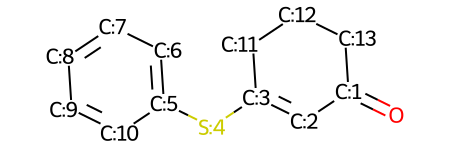

In [4]:
smiles ="O=C1C=C(Sc2ccccc2)CCC1" 
def mol_with_atom_index(mol):
    for atom in mol.GetAtoms():
        atom.SetAtomMapNum(atom.GetIdx())
    return mol

molecule = Chem.MolFromSmiles(smiles)
mol_with_atom_index(molecule)
